In [23]:
import sys
import os
import cv2
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from numpy import asarray
from keras import applications
from keras.models import Model
from keras.preprocessing import image
from keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras import regularizers
from datetime import datetime

In [24]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]

In [25]:
training_data_file = open("./pascal_voc_training_data.txt", "r")
for i, line in enumerate(training_data_file):
    if i > 3:
        break
    line = line.strip()
    print(line)

000005.jpg 263 211 324 339 8 165 264 253 372 8 5 244 67 374 8 241 194 295 299 8 277 186 312 220 8
000007.jpg 141 50 500 330 6
000009.jpg 69 172 270 330 12 150 141 229 284 14 285 201 327 331 14 258 198 297 329 14
000012.jpg 156 97 351 270 6


In [26]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [27]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Select GPU number 1
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [28]:
# common params
IMAGE_SIZE = 448
BATCH_SIZE = 10
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20

# dataset params
DATA_PATH = './pascal_voc_training_data.txt'
IMAGE_DIR = './VOCdevkit_train/VOC2007/JPEGImages/'

# model params
CELL_SIZE = 7
BOXES_PER_CELL = 2
OBJECT_SCALE = 1
NOOBJECT_SCALE = 0.5
CLASS_SCALE = 1
COORD_SCALE = 5

# training params
LEARNING_RATE = 1e-4
EPOCHS = 200

In [29]:
def draw_rect(im, cords, color = None):
    """Draw the rectangle on the image
    
    Parameters
    ----------
    
    im : numpy.ndarray
        numpy image 
    
    cords: numpy.ndarray
        Numpy array containing bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes and the bounding boxes are represented in the
        format `x1 y1 x2 y2`
        
    Returns
    -------
    
    numpy.ndarray
        numpy image with bounding boxes drawn on it
        
    """
    
    im = im.copy()
    
    cords = cords[:,:4]
    cords = cords.reshape(-1,4)
    if not color:
        color = [255,255,255]
    for cord in cords:
        
        pt1, pt2 = (cord[0], cord[1]) , (cord[2], cord[3])
                
        pt1 = int(pt1[0]), int(pt1[1])
        pt2 = int(pt2[0]), int(pt2[1])
    
        im = cv2.rectangle(im.copy(), pt1, pt2, color, int(max(im.shape[:2])/200))
        
    return im


def bbox_area(bbox):
    return (bbox[:,2] - bbox[:,0])*(bbox[:,3] - bbox[:,1])


def clip_box(bbox, clip_box, alpha):
    """Clip the bounding boxes to the borders of an image
    
    Parameters
    ----------
    
    bbox: numpy.ndarray
        Numpy array containing bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes and the bounding boxes are represented in the
        format `x1 y1 x2 y2`
    
    clip_box: numpy.ndarray
        An array of shape (4,) specifying the diagonal co-ordinates of the image
        The coordinates are represented in the format `x1 y1 x2 y2`
        
    alpha: float
        If the fraction of a bounding box left in the image after being clipped is 
        less than `alpha` the bounding box is dropped. 
    
    Returns
    -------
    
    numpy.ndarray
        Numpy array containing **clipped** bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes left are being clipped and the bounding boxes are represented in the
        format `x1 y1 x2 y2` 
    
    """
    ar_ = (bbox_area(bbox))
    x_min = np.maximum(bbox[:,0], clip_box[0]).reshape(-1,1)
    y_min = np.maximum(bbox[:,1], clip_box[1]).reshape(-1,1)
    x_max = np.minimum(bbox[:,2], clip_box[2]).reshape(-1,1)
    y_max = np.minimum(bbox[:,3], clip_box[3]).reshape(-1,1)
    
    bbox = np.hstack((x_min, y_min, x_max, y_max, bbox[:,4:]))
    
    delta_area = ((ar_ - bbox_area(bbox))/ar_)
    
    mask = (delta_area < (1 - alpha)).astype(int)
    
    bbox = bbox[mask == 1,:]

    return bbox


def rotate_im(image, angle):
    """Rotate the image.
    
    Rotate the image such that the rotated image is enclosed inside the tightest
    rectangle. The area not occupied by the pixels of the original image is colored
    black. 
    
    Parameters
    ----------
    
    image : numpy.ndarray
        numpy image
    
    angle : float
        angle by which the image is to be rotated
    
    Returns
    -------
    
    numpy.ndarray
        Rotated Image
    
    """
    # grab the dimensions of the image and then determine the
    # centre
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # perform the actual rotation and return the image
    image = cv2.warpAffine(image, M, (nW, nH))

    # image = cv2.resize(image, (w,h))
    return image


def get_corners(bboxes):
    
    """Get corners of bounding boxes
    
    Parameters
    ----------
    
    bboxes: numpy.ndarray
        Numpy array containing bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes and the bounding boxes are represented in the
        format `x1 y1 x2 y2`
    
    returns
    -------
    
    numpy.ndarray
        Numpy array of shape `N x 8` containing N bounding boxes each described by their 
        corner co-ordinates `x1 y1 x2 y2 x3 y3 x4 y4`      
        
    """
    width = (bboxes[:,2] - bboxes[:,0]).reshape(-1,1)
    height = (bboxes[:,3] - bboxes[:,1]).reshape(-1,1)
    
    x1 = bboxes[:,0].reshape(-1,1)
    y1 = bboxes[:,1].reshape(-1,1)
    
    x2 = x1 + width
    y2 = y1 
    
    x3 = x1
    y3 = y1 + height
    
    x4 = bboxes[:,2].reshape(-1,1)
    y4 = bboxes[:,3].reshape(-1,1)
    
    corners = np.hstack((x1,y1,x2,y2,x3,y3,x4,y4))
    
    return corners


def rotate_box(corners,angle,  cx, cy, h, w):
    
    """Rotate the bounding box.
    
    
    Parameters
    ----------
    
    corners : numpy.ndarray
        Numpy array of shape `N x 8` containing N bounding boxes each described by their 
        corner co-ordinates `x1 y1 x2 y2 x3 y3 x4 y4`
    
    angle : float
        angle by which the image is to be rotated
        
    cx : int
        x coordinate of the center of image (about which the box will be rotated)
        
    cy : int
        y coordinate of the center of image (about which the box will be rotated)
        
    h : int 
        height of the image
        
    w : int 
        width of the image
    
    Returns
    -------
    
    numpy.ndarray
        Numpy array of shape `N x 8` containing N rotated bounding boxes each described by their 
        corner co-ordinates `x1 y1 x2 y2 x3 y3 x4 y4`
    """

    corners = corners.reshape(-1,2)
    corners = np.hstack((corners, np.ones((corners.shape[0],1), dtype = type(corners[0][0]))))
    
    M = cv2.getRotationMatrix2D((cx, cy), angle, 1.0)
    
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cx
    M[1, 2] += (nH / 2) - cy
    # Prepare the vector to be transformed
    calculated = np.dot(M,corners.T).T
    
    calculated = calculated.reshape(-1,8)
    
    return calculated


def get_enclosing_box(corners):
    """Get an enclosing box for ratated corners of a bounding box
    
    Parameters
    ----------
    
    corners : numpy.ndarray
        Numpy array of shape `N x 8` containing N bounding boxes each described by their 
        corner co-ordinates `x1 y1 x2 y2 x3 y3 x4 y4`  
    
    Returns 
    -------
    
    numpy.ndarray
        Numpy array containing enclosing bounding boxes of shape `N X 4` where N is the 
        number of bounding boxes and the bounding boxes are represented in the
        format `x1 y1 x2 y2`
        
    """
    x_ = corners[:,[0,2,4,6]]
    y_ = corners[:,[1,3,5,7]]
    
    xmin = np.min(x_,1).reshape(-1,1)
    ymin = np.min(y_,1).reshape(-1,1)
    xmax = np.max(x_,1).reshape(-1,1)
    ymax = np.max(y_,1).reshape(-1,1)
    
    final = np.hstack((xmin, ymin, xmax, ymax,corners[:,8:]))
    
    return final


def letterbox_image(img, inp_dim):
    '''resize image with unchanged aspect ratio using padding
    
    Parameters
    ----------
    
    img : numpy.ndarray
        Image 
    
    inp_dim: tuple(int)
        shape of the reszied image
        
    Returns
    -------
    
    numpy.ndarray:
        Resized image
    
    '''

    inp_dim = (inp_dim, inp_dim)
    img_w, img_h = img.shape[1], img.shape[0]
    w, h = inp_dim
    new_w = int(img_w * min(w/img_w, h/img_h))
    new_h = int(img_h * min(w/img_w, h/img_h))
    resized_image = cv2.resize(img, (new_w,new_h))
    
    canvas = np.full((inp_dim[1], inp_dim[0], 3), 0)

    canvas[(h-new_h)//2:(h-new_h)//2 + new_h,(w-new_w)//2:(w-new_w)//2 + new_w,  :] = resized_image
    
    return canvas

In [30]:
class RandomHorizontalFlip(object):

    """Randomly horizontally flips the Image with the probability *p*
    Parameters
    ----------
    p: float
        The probability with which the image is flipped
    Returns
    -------
    numpy.ndaaray
        Flipped image in the numpy format of shape `HxWxC`
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
    """

    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, img, bboxes):
            img_center = np.array(img.shape[:2])[::-1]/2
            img_center = np.hstack((img_center, img_center))
            if random.random() < self.p:
                img = img[:, ::-1, :]
                bboxes[:, [0, 2]] += 2*(img_center[[0, 2]] - bboxes[:, [0, 2]])

                box_w = abs(bboxes[:, 0] - bboxes[:, 2])

                bboxes[:, 0] -= box_w
                bboxes[:, 2] += box_w

            return img, bboxes


class HorizontalFlip(object):

    """Randomly horizontally flips the Image with the probability *p*
    Parameters
    ----------
    p: float
        The probability with which the image is flipped
    Returns
    -------
    numpy.ndaaray
        Flipped image in the numpy format of shape `HxWxC`
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
    """

    def __init__(self):
        pass

    def __call__(self, img, bboxes):
        img_center = np.array(img.shape[:2])[::-1]/2
        img_center = np.hstack((img_center, img_center))

        img = img[:, ::-1, :]
        bboxes[:, [0, 2]] += 2*(img_center[[0, 2]] - bboxes[:, [0, 2]])

        box_w = abs(bboxes[:, 0] - bboxes[:, 2])

        bboxes[:, 0] -= box_w
        bboxes[:, 2] += box_w

        return img, bboxes


class RandomScale(object):
    """Randomly scales an image    
    
    
    Bounding boxes which have an area of less than 25% in the remaining in the 
    transformed image is dropped. The resolution is maintained, and the remaining
    area if any is filled by black color.
    
    Parameters
    ----------
    scale: float or tuple(float)
        if **float**, the image is scaled by a factor drawn 
        randomly from a range (1 - `scale` , 1 + `scale`). If **tuple**,
        the `scale` is drawn randomly from values specified by the 
        tuple
        
    Returns
    -------
    
    numpy.ndaaray
        Scaled image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """

    def __init__(self, scale = 0.2, diff = False):
        self.scale = scale

        
        if type(self.scale) == tuple:
            assert len(self.scale) == 2, "Invalid range"
            assert self.scale[0] > -1, "Scale factor can't be less than -1"
            assert self.scale[1] > -1, "Scale factor can't be less than -1"
        else:
            assert self.scale > 0, "Please input a positive float"
            self.scale = (max(-1, -self.scale), self.scale)
        
        self.diff = diff

        

    def __call__(self, img, bboxes):
    
        
        #Chose a random digit to scale by 
        
        img_shape = img.shape
        
        if self.diff:
            scale_x = random.uniform(*self.scale)
            scale_y = random.uniform(*self.scale)
        else:
            scale_x = random.uniform(*self.scale)
            scale_y = scale_x
            
    
        
        resize_scale_x = 1 + scale_x
        resize_scale_y = 1 + scale_y
        
        img=  cv2.resize(img, None, fx = resize_scale_x, fy = resize_scale_y)
        
        bboxes[:,:4] *= [resize_scale_x, resize_scale_y, resize_scale_x, resize_scale_y]
        
        
        
        canvas = np.zeros(img_shape, dtype = np.uint8)
        
        y_lim = int(min(resize_scale_y,1)*img_shape[0])
        x_lim = int(min(resize_scale_x,1)*img_shape[1])
        
        
        canvas[:y_lim,:x_lim,:] =  img[:y_lim,:x_lim,:]
        
        img = canvas
        bboxes = clip_box(bboxes, [0,0,1 + img_shape[1], img_shape[0]], 0.25)
    
    
        return img, bboxes


class Scale(object):
    """Scales the image    
        
    Bounding boxes which have an area of less than 25% in the remaining in the 
    transformed image is dropped. The resolution is maintained, and the remaining
    area if any is filled by black color.
    
    
    Parameters
    ----------
    scale_x: float
        The factor by which the image is scaled horizontally
        
    scale_y: float
        The factor by which the image is scaled vertically
        
    Returns
    -------
    
    numpy.ndaaray
        Scaled image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """

    def __init__(self, scale_x = 0.2, scale_y = 0.2):
        self.scale_x = scale_x
        self.scale_y = scale_y
        

    def __call__(self, img, bboxes):
    
        
        #Chose a random digit to scale by 
        
        img_shape = img.shape
        
        
        resize_scale_x = 1 + self.scale_x
        resize_scale_y = 1 + self.scale_y
        
        img=  cv2.resize(img, None, fx = resize_scale_x, fy = resize_scale_y)
        
        bboxes[:,:4] *= [resize_scale_x, resize_scale_y, resize_scale_x, resize_scale_y]
        
        
        
        canvas = np.zeros(img_shape, dtype = np.uint8)
        
        y_lim = int(min(resize_scale_y,1)*img_shape[0])
        x_lim = int(min(resize_scale_x,1)*img_shape[1])
        
        
        canvas[:y_lim,:x_lim,:] =  img[:y_lim,:x_lim,:]
        
        img = canvas
        bboxes = clip_box(bboxes, [0,0,1 + img_shape[1], img_shape[0]], 0.25)

    
        return img, bboxes  
    

class RandomTranslate(object):
    """Randomly Translates the image    
    
    
    Bounding boxes which have an area of less than 25% in the remaining in the 
    transformed image is dropped. The resolution is maintained, and the remaining
    area if any is filled by black color.
    
    Parameters
    ----------
    translate: float or tuple(float)
        if **float**, the image is translated by a factor drawn 
        randomly from a range (1 - `translate` , 1 + `translate`). If **tuple**,
        `translate` is drawn randomly from values specified by the 
        tuple
        
    Returns
    -------
    
    numpy.ndaaray
        Translated image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """

    def __init__(self, translate = 0.2, diff = False):
        self.translate = translate
        
        if type(self.translate) == tuple:
            assert len(self.translate) == 2, "Invalid range"  
            assert self.translate[0] > 0 & self.translate[0] < 1
            assert self.translate[1] > 0 & self.translate[1] < 1


        else:
            assert self.translate > 0 and self.translate < 1
            self.translate = (-self.translate, self.translate)
            
            
        self.diff = diff

    def __call__(self, img, bboxes):        
        #Chose a random digit to scale by 
        img_shape = img.shape
        
        #translate the image
        
        #percentage of the dimension of the image to translate
        translate_factor_x = random.uniform(*self.translate)
        translate_factor_y = random.uniform(*self.translate)
        
        if not self.diff:
            translate_factor_y = translate_factor_x
            
        canvas = np.zeros(img_shape).astype(np.uint8)
    
    
        corner_x = int(translate_factor_x*img.shape[1])
        corner_y = int(translate_factor_y*img.shape[0])
        
        
        
        #change the origin to the top-left corner of the translated box
        orig_box_cords =  [max(0,corner_y), max(corner_x,0), min(img_shape[0], corner_y + img.shape[0]), min(img_shape[1],corner_x + img.shape[1])]
    
        
        
    
        mask = img[max(-corner_y, 0):min(img.shape[0], -corner_y + img_shape[0]), max(-corner_x, 0):min(img.shape[1], -corner_x + img_shape[1]),:]
        canvas[orig_box_cords[0]:orig_box_cords[2], orig_box_cords[1]:orig_box_cords[3],:] = mask
        img = canvas
        
        bboxes[:,:4] += [corner_x, corner_y, corner_x, corner_y]
        
        
        bboxes = clip_box(bboxes, [0,0,img_shape[1], img_shape[0]], 0.25)
        
    
        
    
        
        return img, bboxes
    

class Translate(object):
    """Randomly Translates the image    
    
    
    Bounding boxes which have an area of less than 25% in the remaining in the 
    transformed image is dropped. The resolution is maintained, and the remaining
    area if any is filled by black color.
    
    Parameters
    ----------
    translate: float or tuple(float)
        if **float**, the image is translated by a factor drawn 
        randomly from a range (1 - `translate` , 1 + `translate`). If **tuple**,
        `translate` is drawn randomly from values specified by the 
        tuple
        
    Returns
    -------
    
    numpy.ndaaray
        Translated image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """

    def __init__(self, translate_x = 0.2, translate_y = 0.2, diff = False):
        self.translate_x = translate_x
        self.translate_y = translate_y

        assert self.translate_x > 0 and self.translate_x < 1
        assert self.translate_y > 0 and self.translate_y < 1
 

    def __call__(self, img, bboxes):        
        #Chose a random digit to scale by 
        img_shape = img.shape
        
        #translate the image
        
        #percentage of the dimension of the image to translate
        translate_factor_x = self.translate_x
        translate_factor_y = self.translate_y
        
            
        canvas = np.zeros(img_shape).astype(np.uint8)

        
        #get the top-left corner co-ordinates of the shifted box 
        corner_x = int(translate_factor_x*img.shape[1])
        corner_y = int(translate_factor_y*img.shape[0])
        
        
        
        #change the origin to the top-left corner of the translated box
        orig_box_cords =  [max(0,corner_y), max(corner_x,0), min(img_shape[0], corner_y + img.shape[0]), min(img_shape[1],corner_x + img.shape[1])]

        
        

        mask = img[max(-corner_y, 0):min(img.shape[0], -corner_y + img_shape[0]), max(-corner_x, 0):min(img.shape[1], -corner_x + img_shape[1]),:]
        canvas[orig_box_cords[0]:orig_box_cords[2], orig_box_cords[1]:orig_box_cords[3],:] = mask
        img = canvas
        
        bboxes[:,:4] += [corner_x, corner_y, corner_x, corner_y]
        
        
        bboxes = clip_box(bboxes, [0,0,img_shape[1], img_shape[0]], 0.25)
        

        

        
        return img, bboxes
    
    
class RandomRotate(object):
    """Randomly rotates an image    
    
    
    Bounding boxes which have an area of less than 25% in the remaining in the 
    transformed image is dropped. The resolution is maintained, and the remaining
    area if any is filled by black color.
    
    Parameters
    ----------
    angle: float or tuple(float)
        if **float**, the image is rotated by a factor drawn 
        randomly from a range (-`angle`, `angle`). If **tuple**,
        the `angle` is drawn randomly from values specified by the 
        tuple
        
    Returns
    -------
    
    numpy.ndaaray
        Rotated image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """

    def __init__(self, angle = 10):
        self.angle = angle
        
        if type(self.angle) == tuple:
            assert len(self.angle) == 2, "Invalid range"  
            
        else:
            self.angle = (-self.angle, self.angle)
            
    def __call__(self, img, bboxes):
    
        angle = random.uniform(*self.angle)
    
        w,h = img.shape[1], img.shape[0]
        cx, cy = w//2, h//2
    
        img = rotate_im(img, angle)
    
        corners = get_corners(bboxes)
    
        corners = np.hstack((corners, bboxes[:,4:]))
    
    
        corners[:,:8] = rotate_box(corners[:,:8], angle, cx, cy, h, w)
    
        new_bbox = get_enclosing_box(corners)
    
    
        scale_factor_x = img.shape[1] / w
    
        scale_factor_y = img.shape[0] / h
    
        img = cv2.resize(img, (w,h))
    
        new_bbox[:,:4] /= [scale_factor_x, scale_factor_y, scale_factor_x, scale_factor_y] 
    
        bboxes  = new_bbox
    
        bboxes = clip_box(bboxes, [0,0,w, h], 0.25)
    
        return img, bboxes

    
class Rotate(object):
    """Rotates an image    
    
    
    Bounding boxes which have an area of less than 25% in the remaining in the 
    transformed image is dropped. The resolution is maintained, and the remaining
    area if any is filled by black color.
    
    Parameters
    ----------
    angle: float
        The angle by which the image is to be rotated 
        
        
    Returns
    -------
    
    numpy.ndaaray
        Rotated image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """

    def __init__(self, angle):
        self.angle = angle
        

    def __call__(self, img, bboxes):
        """
        Args:
            img (PIL Image): Image to be flipped.
        Returns:
            PIL Image: Randomly flipped image.
            
            
        """
        
        angle = self.angle
        print(self.angle)
        
        w,h = img.shape[1], img.shape[0]
        cx, cy = w//2, h//2
        
        corners = get_corners(bboxes)
        
        corners = np.hstack((corners, bboxes[:,4:]))

        img = rotate_im(img, angle)
        
        corners[:,:8] = rotate_box(corners[:,:8], angle, cx, cy, h, w)
        
        
        
        
        new_bbox = get_enclosing_box(corners)
        
        
        scale_factor_x = img.shape[1] / w
        
        scale_factor_y = img.shape[0] / h
        
        img = cv2.resize(img, (w,h))
        
        new_bbox[:,:4] /= [scale_factor_x, scale_factor_y, scale_factor_x, scale_factor_y] 
        
        
        bboxes  = new_bbox

        bboxes = clip_box(bboxes, [0,0,w, h], 0.25)
        
        return img, bboxes
        


class RandomShear(object):
    """Randomly shears an image in horizontal direction   
    
    
    Bounding boxes which have an area of less than 25% in the remaining in the 
    transformed image is dropped. The resolution is maintained, and the remaining
    area if any is filled by black color.
    
    Parameters
    ----------
    shear_factor: float or tuple(float)
        if **float**, the image is sheared horizontally by a factor drawn 
        randomly from a range (-`shear_factor`, `shear_factor`). If **tuple**,
        the `shear_factor` is drawn randomly from values specified by the 
        tuple
        
    Returns
    -------
    
    numpy.ndaaray
        Sheared image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """

    def __init__(self, shear_factor = 0.2):
        self.shear_factor = shear_factor
        
        if type(self.shear_factor) == tuple:
            assert len(self.shear_factor) == 2, "Invalid range for scaling factor"   
        else:
            self.shear_factor = (-self.shear_factor, self.shear_factor)
        
        shear_factor = random.uniform(*self.shear_factor)
        
    def __call__(self, img, bboxes):
    
        shear_factor = random.uniform(*self.shear_factor)
    
        w,h = img.shape[1], img.shape[0]
    
        if shear_factor < 0:
            img, bboxes = HorizontalFlip()(img, bboxes)
    
        M = np.array([[1, abs(shear_factor), 0],[0,1,0]])
    
        nW =  img.shape[1] + abs(shear_factor*img.shape[0])
    
        bboxes[:,[0,2]] += ((bboxes[:,[1,3]]) * abs(shear_factor) ).astype(int) 
    
    
        img = cv2.warpAffine(img, M, (int(nW), img.shape[0]))
    
        if shear_factor < 0:
        	img, bboxes = HorizontalFlip()(img, bboxes)
    
        img = cv2.resize(img, (w,h))
    
        scale_factor_x = nW / w
    
        bboxes[:,:4] /= [scale_factor_x, 1, scale_factor_x, 1] 
    
    
        return img, bboxes
        
class Shear(object):
    """Shears an image in horizontal direction   
    
    
    Bounding boxes which have an area of less than 25% in the remaining in the 
    transformed image is dropped. The resolution is maintained, and the remaining
    area if any is filled by black color.
    
    Parameters
    ----------
    shear_factor: float
        Factor by which the image is sheared in the x-direction
       
    Returns
    -------
    
    numpy.ndaaray
        Sheared image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Tranformed bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """

    def __init__(self, shear_factor = 0.2):
        self.shear_factor = shear_factor
        
    
    def __call__(self, img, bboxes):
        
        shear_factor = self.shear_factor
        if shear_factor < 0:
            img, bboxes = HorizontalFlip()(img, bboxes)

        
        M = np.array([[1, abs(shear_factor), 0],[0,1,0]])
                
        nW =  img.shape[1] + abs(shear_factor*img.shape[0])
        
        bboxes[:,[0,2]] += ((bboxes[:,[1,3]])*abs(shear_factor)).astype(int) 
        

        img = cv2.warpAffine(img, M, (int(nW), img.shape[0]))
        
        if shear_factor < 0:
             img, bboxes = HorizontalFlip()(img, bboxes)
             
        
        return img, bboxes
    
class Resize(object):
    """Resize the image in accordance to `image_letter_box` function in darknet 
    
    The aspect ratio is maintained. The longer side is resized to the input 
    size of the network, while the remaining space on the shorter side is filled 
    with black color. **This should be the last transform**
    
    
    Parameters
    ----------
    inp_dim : tuple(int)
        tuple containing the size to which the image will be resized.
        
    Returns
    -------
    
    numpy.ndaaray
        Sheared image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Resized bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """
    
    def __init__(self, inp_dim):
        self.inp_dim = inp_dim
        
    def __call__(self, img, bboxes):
        w,h = img.shape[1], img.shape[0]
        img = letterbox_image(img, self.inp_dim)
    
    
        scale = min(self.inp_dim/h, self.inp_dim/w)
        bboxes[:,:4] *= (scale)
    
        new_w = scale*w
        new_h = scale*h
        inp_dim = self.inp_dim   
    
        del_h = (inp_dim - new_h)/2
        del_w = (inp_dim - new_w)/2
    
        add_matrix = np.array([[del_w, del_h, del_w, del_h]]).astype(int)
    
        bboxes[:,:4] += add_matrix
    
        img = img.astype(np.uint8)
    
        return img, bboxes 
    

class RandomHSV(object):
    """HSV Transform to vary hue saturation and brightness
    
    Hue has a range of 0-179
    Saturation and Brightness have a range of 0-255. 
    Chose the amount you want to change thhe above quantities accordingly. 
    
    
    
    
    Parameters
    ----------
    hue : None or int or tuple (int)
        If None, the hue of the image is left unchanged. If int, 
        a random int is uniformly sampled from (-hue, hue) and added to the 
        hue of the image. If tuple, the int is sampled from the range 
        specified by the tuple.   
        
    saturation : None or int or tuple(int)
        If None, the saturation of the image is left unchanged. If int, 
        a random int is uniformly sampled from (-saturation, saturation) 
        and added to the hue of the image. If tuple, the int is sampled
        from the range  specified by the tuple.   
        
    brightness : None or int or tuple(int)
        If None, the brightness of the image is left unchanged. If int, 
        a random int is uniformly sampled from (-brightness, brightness) 
        and added to the hue of the image. If tuple, the int is sampled
        from the range  specified by the tuple.   
    
    Returns
    -------
    
    numpy.ndaaray
        Transformed image in the numpy format of shape `HxWxC`
    
    numpy.ndarray
        Resized bounding box co-ordinates of the format `n x 4` where n is 
        number of bounding boxes and 4 represents `x1,y1,x2,y2` of the box
        
    """
    
    def __init__(self, hue = None, saturation = None, brightness = None):
        if hue:
            self.hue = hue 
        else:
            self.hue = 0
            
        if saturation:
            self.saturation = saturation 
        else:
            self.saturation = 0
            
        if brightness:
            self.brightness = brightness
        else:
            self.brightness = 0
            
            

        if type(self.hue) != tuple:
            self.hue = (-self.hue, self.hue)
            
        if type(self.saturation) != tuple:
            self.saturation = (-self.saturation, self.saturation)
        
        if type(brightness) != tuple:
            self.brightness = (-self.brightness, self.brightness)
    
    def __call__(self, img, bboxes):

        hue = random.randint(*self.hue)
        saturation = random.randint(*self.saturation)
        brightness = random.randint(*self.brightness)
        
        img = img.astype(int)
        
        a = np.array([hue, saturation, brightness]).astype(int)
        img += np.reshape(a, (1,1,3))
        
        img = np.clip(img, 0, 255)
        img[:,:,0] = np.clip(img[:,:,0],0, 179)
        
        img = img.astype(np.uint8)

        
        
        return img, bboxes
    
class Sequence(object):

    """Initialise Sequence object
    
    Apply a Sequence of transformations to the images/boxes.
    
    Parameters
    ----------
    augemnetations : list 
        List containing Transformation Objects in Sequence they are to be 
        applied
    
    probs : int or list 
        If **int**, the probability with which each of the transformation will 
        be applied. If **list**, the length must be equal to *augmentations*. 
        Each element of this list is the probability with which each 
        corresponding transformation is applied
    
    Returns
    -------
    
    Sequence
        Sequence Object 
        
    """
    def __init__(self, augmentations, probs = 1):

        
        self.augmentations = augmentations
        self.probs = probs
        
    def __call__(self, images, bboxes):
        for i, augmentation in enumerate(self.augmentations):
            if type(self.probs) == list:
                prob = self.probs[i]
            else:
                prob = self.probs
                
            if random.random() < prob:
                images, bboxes = augmentation(images, bboxes)
        return images, bboxes

In [31]:
def oversample(input_file):
    img_container = [[] for i in range(20)]
    oversample_data = []

    for line in input_file:
        line = line.strip()
        oversample_data.append(line)
        
        img_labels = line.split(" ")[5::5]
        img_labels_counter = np.zeros(20)  
        for i in img_labels:
            img_labels_counter[int(i)] += 1
        
        # to deal with the problem of large amount of human
        if img_labels_counter[14] > 0:
            img_container[14].append(line)
        else:
            img_container[np.argmax(img_labels_counter)].append(line)


    imgNum_of_class = [len(img) for img in img_container]
    threshold = max(imgNum_of_class) // 6
    
    sampled_data = []
    for i in range(20):
        if imgNum_of_class[i] < threshold :
            sampled_data.extend(random.choices(img_container[i], k = threshold - imgNum_of_class[i]))

    oversample_data.extend(sampled_data)
    
    with open('oversample_training_data.txt', 'w') as f:
        for item in oversample_data:
            f.write("%s\n" % item)
            
##################################################

    oversample_file = open('oversample_training_data.txt', 'r')
    
    img_container = [[] for i in range(20)]
    
    for line in oversample_file:
        line = line.strip()
        
        img_labels = line.split(" ")[5::5]
        img_labels_counter = np.zeros(20)  
        for i in img_labels:
            img_labels_counter[int(i)] += 1
        
        img_container[np.argmax(img_labels_counter)].append(line)

    imgNum_of_class = [len(img) for img in img_container]
    
    aug_probability = (np.max(imgNum_of_class) - imgNum_of_class) / imgNum_of_class / 10
    return aug_probability

In [32]:
import skimage
def aug (input_file, catagory_prop):
    
    select_data = []
    # #################################
    # input_file = open(DATA_PATH, 'r')
    # p=1
    # #################################

    for line in input_file:
        line = line.strip()
        ss = line.split(' ')
        select_data.append(ss)
            
    with open("./oversample_training_data.txt", 'a') as f:
        
        for data in select_data :
            image_name = data[0]
            image_file = Image.open(IMAGE_DIR + image_name)
            image = np.array(image_file)
            box = np.reshape(data[1:] , (-1,5)).astype(np.int)
            classes = box[:,4]
            max_class = np.argmax(np.bincount(classes))
            
            if (len(np.bincount(classes)) > 14) and (np.bincount(classes)[14]) > 0:
                p = catagory_prop[14]
            else:
                p = catagory_prop[max_class]
                
            box = box.astype('float64')
            
            if random.random() < p :
                img_flip, bboxes_flip = RandomHorizontalFlip(1)(image.copy(), box.copy())
                bboxes_flip = bboxes_flip.flatten().astype(int)
                label = image_name[:-4]+ '_flip.jpg'
                
                for i in (bboxes_flip):
                    label = label + ' '+str(i)
                
                data = Image.fromarray(img_flip)
                data.save(IMAGE_DIR + image_name[:-4]+ '_flip.jpg')
                f.writelines([label + '\n'])

            if random.random() < p :
                # (-angle, angle) random rotate
                img_rotate, bboxes_rotate = RandomRotate(45)(image.copy(), box.copy())
                bboxes_rotate = bboxes_rotate.flatten().astype(int)
                label = image_name[:-4]+ '_rotate.jpg'
                
                for i in (bboxes_rotate):
                    label = label + ' '+str(i)
                    
                data = Image.fromarray(img_rotate)
                data.save(IMAGE_DIR + image_name[:-4]+ '_rotate.jpg')        
                f.writelines([label + '\n'])

            if random.random() < p :
                
                hue = 10*random.randint(1, 10)
                saturation = 10*random.randint(1, 10)
                brightness = 10*random.randint(1, 10)    
                
                img_HSV, bboxes_HSV = RandomHSV(hue, saturation, brightness)(image.copy(), box.copy())
                bboxes_HSV = bboxes_HSV.flatten().astype(int)
                label = image_name[:-4]+ '_hsv.jpg'
                
                for i in (bboxes_HSV):
                    label = label + ' '+str(i)

                data = Image.fromarray(img_HSV)
                data.save(IMAGE_DIR + image_name[:-4]+ '_hsv.jpg')
                f.writelines([label + '\n'])

            if random.random() < p :
                img_shear, bboxes_shear = RandomShear(0.2)(image.copy(), box.copy())
                bboxes_shear = bboxes_shear.flatten().astype(int)
                label = image_name[:-4]+ '_shear.jpg'
                
                for i in (bboxes_shear):
                    label = label + ' '+str(i)
                
                data = Image.fromarray(img_shear)
                data.save(IMAGE_DIR + image_name[:-4]+ '_shear.jpg')
                f.writelines([label + '\n'])
            
            if random.random() < p :
                img_scale, bboxes_scale = RandomScale(0.2, diff = True)(image.copy(), box.copy())
                bboxes_scale = bboxes_scale.flatten().astype(int)
                label = image_name[:-4]+ '_scale.jpg'
                
                for i in (bboxes_scale):
                    label = label + ' '+str(i)
                
                data = Image.fromarray(img_scale)
                data.save(IMAGE_DIR + image_name[:-4]+ '_scale.jpg')
                f.writelines([label + '\n'])

#####################################################ALOHG+HSIN AUG 8##################################################
            if random.random() < p :
                # pepper noise
                img_pepper = skimage.util.random_noise(image,mode="pepper",clip=True) * 255.0
                img_pepper = np.rint(img_pepper).astype(np.uint8)
                bboxes_pepper = box
                bboxes_pepper = bboxes_pepper.flatten().astype(int)
                label = image_name[:-4]+ '_pepper.jpg'

                for i in (bboxes_pepper):
                    label = label + ' '+str(i)
                
                data = Image.fromarray(img_pepper)
                data.save(IMAGE_DIR + image_name[:-4]+ '_pepper.jpg')
                f.writelines([label + '\n'])
                
            if random.random() < p :
                # salt noise
                img_salt = skimage.util.random_noise(image,mode="salt",clip=True) * 255.0
                img_salt = np.rint(img_salt).astype(np.uint8)
                bboxes_salt = box
                bboxes_salt = bboxes_salt.flatten().astype(int)
                label = image_name[:-4]+ '_salt.jpg'

                for i in (bboxes_salt):
                    label = label + ' '+str(i)
                
                data = Image.fromarray(img_salt)
                data.save(IMAGE_DIR + image_name[:-4]+ '_salt.jpg')
                f.writelines([label + '\n'])
            
            if random.random() < p :
                # gaussian noise
                img_gaussian = skimage.util.random_noise(image,mode="gaussian",clip=True,mean=0,var=0.05) * 255.0
                img_gaussian = np.rint(img_gaussian).astype(np.uint8)
                bboxes_gaussian = box        
                bboxes_gaussian = bboxes_gaussian.flatten().astype(int)
                label = image_name[:-4]+ '_gaussian.jpg'

                for i in (bboxes_gaussian):
                    label = label + ' '+str(i)
                
                data = Image.fromarray(img_gaussian)
                data.save(IMAGE_DIR + image_name[:-4]+ '_gaussian.jpg')
                f.writelines([label + '\n'])

            if random.random() < p :
                # speckle noise
                img_speckle = skimage.util.random_noise(image,mode="speckle",clip=True,mean=0,var=0.05) * 255.0
                img_speckle = np.rint(img_speckle).astype(np.uint8)
                bboxes_speckle = box
                bboxes_speckle = bboxes_speckle.flatten().astype(int)
                label = image_name[:-4]+ '_speckle.jpg'

                for i in (bboxes_speckle):
                    label = label + ' '+str(i)
                
                data = Image.fromarray(img_speckle)
                data.save(IMAGE_DIR + image_name[:-4]+ '_speckle.jpg')
                f.writelines([label + '\n'])
            
            if random.random() < p :
                # salt & pepper noise
                img_saltpepper = skimage.util.random_noise(image,mode="s&p",clip=True,amount=0.1) * 255.0
                img_saltpepper = np.rint(img_saltpepper).astype(np.uint8)
                bboxes_saltpepper = box
                bboxes_saltpepper = bboxes_saltpepper.flatten().astype(int)
                label = image_name[:-4]+ '_saltpepper.jpg'

                for i in (bboxes_saltpepper):
                    label = label + ' '+str(i)
                data = Image.fromarray(img_saltpepper)
                data.save(IMAGE_DIR + image_name[:-4]+ '_saltpepper.jpg')
                f.writelines([label + '\n'])

            # if random.random() < p :
            #     # mix image
            #     hue = 10*random.randint(1, 10)
            #     saturation = 10*random.randint(1, 10)
            #     brightness = 10*random.randint(1, 10)   

            #     seq = Sequence([RandomHSV(hue, saturation, brightness),RandomHorizontalFlip(), RandomScale(0.2, diff = True), RandomRotate(10), RandomShear(0.2)])
            #     img_mix, bboxes_mix = seq(image.copy(), box.copy())

            #     # plot_img = draw_rect(image,box)
            #     # plt.imshow(plot_img)
            #     # plt.show()

            #     # noise_plot_img = draw_rect(img_mix,bboxes_mix)
            #     # plt.imshow(plot_img)
            #     # plt.show()

            #     # break
            #     bboxes_mix = bboxes_mix.flatten().astype(int)
            #     label = image_name[:-4]+ '_mix.jpg'
                
            #     for i in (bboxes_mix):
            #         label = label + ' '+str(i)
                
                
            #     data = Image.fromarray(img_mix)
            #     data.save(IMAGE_DIR + image_name[:-4]+ '_mix.jpg')
            #     f.writelines([label + '\n'])
                
                
            image_file.close()

In [33]:
# aug('./pascal_voc_training_data.txt', [])

In [34]:
class DatasetGenerator:
    """
    Load pascalVOC 2007 dataset and creates an input pipeline.
    - Reshapes images into 448 x 448
    - converts [0 1] to [-1 1]
    - shuffles the input
    - builds batches
    """

    def __init__(self):
        self.image_names = []
        self.record_list = []
        self.object_num_list = []
        # filling the record_list

        input_file = open(DATA_PATH, 'r')
        aug_probability = oversample(input_file)
        input_file.close()

        oversample_file = open("./oversample_training_data.txt",'r')
        aug(oversample_file , aug_probability)
        
        oversample_file.close()
        oversample_file = open("./oversample_training_data.txt",'r')
        for line in oversample_file:
            line = line.strip()
            ss = line.split(' ')
            self.image_names.append(ss[0])

            self.record_list.append([float(num) for num in ss[1:]])

            self.object_num_list.append(min(len(self.record_list[-1])//5, 
                                            MAX_OBJECTS_PER_IMAGE))
            if len(self.record_list[-1]) < MAX_OBJECTS_PER_IMAGE*5:
                # if there are objects less than MAX_OBJECTS_PER_IMAGE, pad the list
                self.record_list[-1] = self.record_list[-1] +\
                [0., 0., 0., 0., 0.]*\
                (MAX_OBJECTS_PER_IMAGE-len(self.record_list[-1])//5)
                
            elif len(self.record_list[-1]) > MAX_OBJECTS_PER_IMAGE*5:
               # if there are objects more than MAX_OBJECTS_PER_IMAGE, crop the list
                self.record_list[-1] = self.record_list[-1][:MAX_OBJECTS_PER_IMAGE*5]
                
        oversample_file.close()

    def _data_preprocess(self, image_name, raw_labels, object_num):
        image_file = tf.io.read_file(IMAGE_DIR+image_name)
        image = tf.io.decode_jpeg(image_file, channels=3)

        h = tf.shape(image)[0]
        w = tf.shape(image)[1]

        width_ratio  = IMAGE_SIZE * 1.0 / tf.cast(w, tf.float32) 
        height_ratio = IMAGE_SIZE * 1.0 / tf.cast(h, tf.float32) 

        image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = (image/255) * 2 - 1
#         image = preprocess_input(image)
        raw_labels = tf.cast(tf.reshape(raw_labels, [-1, 5]), tf.float32)

        xmin = raw_labels[:, 0]
        ymin = raw_labels[:, 1]
        xmax = raw_labels[:, 2]
        ymax = raw_labels[:, 3]
        class_num = raw_labels[:, 4]

        xcenter = (xmin + xmax) * 1.0 / 2.0 * width_ratio
        ycenter = (ymin + ymax) * 1.0 / 2.0 * height_ratio

        box_w = (xmax - xmin) * width_ratio
        box_h = (ymax - ymin) * height_ratio

        labels = tf.stack([xcenter, ycenter, box_w, box_h, class_num], axis=1)

        return image, labels, tf.cast(object_num, tf.int32)

    def generate(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.image_names, 
                                                      np.array(self.record_list), 
                                                      np.array(self.object_num_list)))
        dataset = dataset.shuffle(100000)
        dataset = dataset.map(self._data_preprocess, 
                              num_parallel_calls = tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
        dataset = dataset.prefetch(buffer_size=200)

        return dataset

In [35]:
from keras.regularizers import l2

In [36]:
class conv_leaky_relu(Model):
	def __init__(self, filters, size, stride):
		super(conv_leaky_relu, self).__init__()

		self.conv = layers.Conv2D(filters, size, stride, padding="same", kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01), kernel_regularizer=l2(5e-4), use_bias=False)
		self.bn = keras.layers.BatchNormalization()
		self.LeakyReLU = layers.LeakyReLU(0.1)

	def call(self, inputs, training=False):
		x = self.bn(self.conv(inputs), training=training)
		x = self.LeakyReLU(x)
		return x


class yolo(Model):
	def __init__(self, training):
		super(yolo, self).__init__()

		self.training = training

		# self.backbone = ResNet50(include_top=False, weights='imagenet')
		# self.backbone = ResNet50V2(include_top=False, weights='imagenet')
		# self.backbone = Xception(include_top=False, weights='imagenet')
		# self.backbone = NASNetLarge(include_top=False, weights='imagenet')
		self.backbone = keras.applications.InceptionResNetV2(include_top=False, weights='imagenet')

		for layer in self.backbone.layers:
			layer.trainable = False
			# layer.trainable = True
		self.conv1 = conv_leaky_relu(1024, 3, 1)
		self.conv2 = conv_leaky_relu(1024, 3, 2)
		self.conv3 = conv_leaky_relu(1024, 3, 1)
		self.conv4 = conv_leaky_relu(1024, 3, 1)
		self.flatten = layers.Flatten()
		self.dense1 = layers.Dense(4096, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01), kernel_regularizer=l2(5e-4), use_bias=False)
		self.bn1 = keras.layers.BatchNormalization()
		self.leakyRelu1 = layers.LeakyReLU(0.1)
		self.dense3 = layers.Dense(2048, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01), kernel_regularizer=l2(5e-4), use_bias=False)
		self.bn3 = keras.layers.BatchNormalization()
		self.leakyRelu3 = layers.LeakyReLU(0.1)
		self.dense2 = layers.Dense(1470, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01), kernel_regularizer=l2(5e-4))

	def call(self, inputs):
		x = self.backbone(inputs)
		x = self.conv1(x, training=self.training)
		x = self.conv2(x, training=self.training)
		x = self.conv3(x, training=self.training)
		x = self.conv4(x, training=self.training)
		x = self.flatten(x)
		x = self.bn1(self.dense1(x), training=self.training)
		x = self.leakyRelu1(x)
		x = self.bn3(self.dense3(x), training=self.training)
		x = self.leakyRelu3(x)
		x = self.dense2(x)
		return x

In [37]:
YOLO = yolo(training=True)
YOLO.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, 3))

In [38]:
# def conv_leaky_relu(inputs, filters, size, stride):
#     x = layers.Conv2D(filters, size, stride, padding="same",
#                       kernel_regularizer=regularizers.l2(l2=1e-4),
#                       bias_regularizer=regularizers.l2(1e-4),
#                       kernel_initializer=tf.keras.initializers.TruncatedNormal())(inputs)
#     x = layers.BatchNormalization()(x)
#     x = layers.LeakyReLU(0.1)(x)

#     return x

In [39]:
# img_inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
# print(img_inputs)

# base_model = keras.applications.InceptionResNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')
# # base_model = keras.applications.ResNet152(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')
# # base_model.trainable = False
# # x = base_model(img_inputs,  training=False)
# x = base_model(img_inputs)
# x = conv_leaky_relu(x, 1024, 3, 1)
# x = conv_leaky_relu(x, 1024, 3, 2)
# x = conv_leaky_relu(x, 1024, 3, 1)
# x = conv_leaky_relu(x, 1024, 3, 1)
# x = layers.Flatten()(x)
# x = layers.Dense(4096, 
#                  kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)
# x = layers.LeakyReLU(0.1)(x)
# outputs = layers.Dense(1470, 
#                        kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.01))(x)

# YOLO = keras.Model(inputs=img_inputs, outputs=outputs, name="YOLO")

In [40]:
YOLO.summary()

Model: "yolo_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, None, None, 1536)  54336736  
_________________________________________________________________
conv_leaky_relu_4 (conv_leak multiple                  14159872  
_________________________________________________________________
conv_leaky_relu_5 (conv_leak multiple                  9441280   
_________________________________________________________________
conv_leaky_relu_6 (conv_leak multiple                  9441280   
_________________________________________________________________
conv_leaky_relu_7 (conv_leak multiple                  9441280   
_________________________________________________________________
flatten_1 (Flatten)          multiple                  0         
_________________________________________________________________
dense_3 (Dense)              multiple                  15099

In [41]:
# base boxes (for loss calculation)
base_boxes = np.zeros([CELL_SIZE, CELL_SIZE, 4])

# initializtion for each cell
for y in range(CELL_SIZE):
    for x in range(CELL_SIZE):
        base_boxes[y, x, :] = [IMAGE_SIZE / CELL_SIZE * x, 
                               IMAGE_SIZE / CELL_SIZE * y, 0, 0]

base_boxes = np.resize(base_boxes, [CELL_SIZE, CELL_SIZE, 1, 4])
base_boxes = np.tile(base_boxes, [1, 1, BOXES_PER_CELL, 1])

In [42]:
def yolo_loss(predicts, labels, objects_num):
    """
    Add Loss to all the trainable variables
    Args:
        predicts: 4-D tensor [batch_size, cell_size, cell_size, num_classes + 5 * boxes_per_cell]
        ===> (num_classes, boxes_per_cell, 4 * boxes_per_cell)
        labels  : 3-D tensor of [batch_size, max_objects, 5]
        objects_num: 1-D tensor [batch_size]
    """

    loss = 0.
    
    #you can parallel the code with tf.map_fn or tf.vectorized_map (big performance gain!)
    for i in tf.range(BATCH_SIZE):
        predict = predicts[i, :, :, :]
        label = labels[i, :, :]
        object_num = objects_num[i]

        for j in tf.range(object_num):
            results = losses_calculation(predict, label[j:j+1, :])
            loss = loss + results

    return loss/BATCH_SIZE

In [43]:
def iou(boxes1, boxes2):
    """calculate ious
    Args:
      boxes1: 4-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 4]  ====> (x_center, y_center, w, h)
      boxes2: 1-D tensor [4] ===> (x_center, y_center, w, h)

    Return:
      iou: 3-D tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
      ====> iou score for each cell
    """

    #boxes1 : [4(xmin, ymin, xmax, ymax), cell_size, cell_size, boxes_per_cell]
    boxes1 = tf.stack([boxes1[:, :, :, 0] - boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] - boxes1[:, :, :, 3] / 2,
                      boxes1[:, :, :, 0] + boxes1[:, :, :, 2] / 2, boxes1[:, :, :, 1] + boxes1[:, :, :, 3] / 2])

    #boxes1 : [cell_size, cell_size, boxes_per_cell, 4(xmin, ymin, xmax, ymax)]
    boxes1 = tf.transpose(boxes1, [1, 2, 3, 0])

    boxes2 =  tf.stack([boxes2[0] - boxes2[2] / 2, boxes2[1] - boxes2[3] / 2,
                      boxes2[0] + boxes2[2] / 2, boxes2[1] + boxes2[3] / 2])

    #calculate the left up point of boxes' overlap area
    lu = tf.maximum(boxes1[:, :, :, 0:2], boxes2[0:2])
    #calculate the right down point of boxes overlap area
    rd = tf.minimum(boxes1[:, :, :, 2:], boxes2[2:])

    #intersection
    intersection = rd - lu 

    #the size of the intersection area
    inter_square = intersection[:, :, :, 0] * intersection[:, :, :, 1]

    mask = tf.cast(intersection[:, :, :, 0] > 0, tf.float32) * tf.cast(intersection[:, :, :, 1] > 0, tf.float32)

    #if intersection is negative, then the boxes don't overlap
    inter_square = mask * inter_square

    #calculate the boxs1 square and boxs2 square
    square1 = (boxes1[:, :, :, 2] - boxes1[:, :, :, 0]) * (boxes1[:, :, :, 3] - boxes1[:, :, :, 1])
    square2 = (boxes2[2] - boxes2[0]) * (boxes2[3] - boxes2[1])

    return inter_square/(square1 + square2 - inter_square + 1e-6)

def losses_calculation(predict, label):
    """
    calculate loss
    Args:
      predict: 3-D tensor [cell_size, cell_size, num_classes + 5 * boxes_per_cell]
      label : [1, 5]  (x_center, y_center, w, h, class)
    """
    label = tf.reshape(label, [-1])

    #Step A. calculate objects tensor [CELL_SIZE, CELL_SIZE]
    #turn pixel position into cell position (corner)
    min_x = (label[0] - label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_x = (label[0] + label[2] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_y = (label[1] - label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)
    max_y = (label[1] + label[3] / 2) / (IMAGE_SIZE / CELL_SIZE)

    min_x = tf.floor(min_x)
    min_y = tf.floor(min_y)

    max_x = tf.minimum(tf.math.ceil(max_x), CELL_SIZE)
    max_y = tf.minimum(tf.math.ceil(max_y), CELL_SIZE)
    
    #calculate mask of object with cells
    onset = tf.cast(tf.stack([max_y - min_y, max_x - min_x]), dtype=tf.int32)
    object_mask = tf.ones(onset, tf.float32)

    offset = tf.cast(tf.stack([min_y, CELL_SIZE - max_y, min_x, CELL_SIZE - max_x]), tf.int32)
    offset = tf.reshape(offset, (2, 2))
    object_mask = tf.pad(object_mask, offset, "CONSTANT")

    #Step B. calculate the coordination of object center and the corresponding mask
    #turn pixel position into cell position (center)
    center_x = label[0] / (IMAGE_SIZE / CELL_SIZE)
    center_x = tf.floor(center_x)

    center_y = label[1] / (IMAGE_SIZE / CELL_SIZE)
    center_y = tf.floor(center_y)

    response = tf.ones([1, 1], tf.float32)

    #calculate the coordination of object center with cells
    objects_center_coord = tf.cast(tf.stack([center_y, CELL_SIZE - center_y - 1, 
                             center_x, CELL_SIZE - center_x - 1]), 
                             tf.int32)
    objects_center_coord = tf.reshape(objects_center_coord, (2, 2))

    #make mask
    response = tf.pad(response, objects_center_coord, "CONSTANT")

    #Step C. calculate iou_predict_truth [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    predict_boxes = predict[:, :, NUM_CLASSES + BOXES_PER_CELL:]

    predict_boxes = tf.reshape(predict_boxes, [CELL_SIZE, 
                                               CELL_SIZE, 
                                               BOXES_PER_CELL, 4])
    #cell position to pixel position
    predict_boxes = predict_boxes * [IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE / CELL_SIZE, 
                                     IMAGE_SIZE, IMAGE_SIZE]

    #if there's no predict_box in that cell, then the base_boxes will be calcuated with label and got iou equals 0
    predict_boxes = base_boxes + predict_boxes

    iou_predict_truth = iou(predict_boxes, label[0:4])

    #calculate C tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    C = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    #calculate I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    I = iou_predict_truth * tf.reshape(response, [CELL_SIZE, CELL_SIZE, 1])

    max_I = tf.reduce_max(I, 2, keepdims=True)

    #replace large iou scores with response (object center) value
    I = tf.cast((I >= max_I), tf.float32) * tf.reshape(response, (CELL_SIZE, CELL_SIZE, 1))

    #calculate no_I tensor [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    no_I = tf.ones_like(I, dtype=tf.float32) - I

    p_C = predict[:, :, NUM_CLASSES:NUM_CLASSES + BOXES_PER_CELL]

    #calculate truth x, y, sqrt_w, sqrt_h 0-D
    x = label[0]
    y = label[1]

    sqrt_w = tf.sqrt(tf.abs(label[2]))
    sqrt_h = tf.sqrt(tf.abs(label[3]))

    #calculate predict p_x, p_y, p_sqrt_w, p_sqrt_h 3-D [CELL_SIZE, CELL_SIZE, BOXES_PER_CELL]
    p_x = predict_boxes[:, :, :, 0]
    p_y = predict_boxes[:, :, :, 1]

    p_sqrt_w = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 2])))
    p_sqrt_h = tf.sqrt(tf.minimum(IMAGE_SIZE * 1.0, tf.maximum(0.0, predict_boxes[:, :, :, 3])))

    #calculate ground truth p 1-D tensor [NUM_CLASSES]
    P = tf.one_hot(tf.cast(label[4], tf.int32), NUM_CLASSES, dtype=tf.float32)

    #calculate predicted p_P 3-D tensor [CELL_SIZE, CELL_SIZE, NUM_CLASSES]
    p_P = predict[:, :, 0:NUM_CLASSES]

    #class_loss
    class_loss = tf.nn.l2_loss(tf.reshape(object_mask, (CELL_SIZE, CELL_SIZE, 1)) * (p_P - P)) * CLASS_SCALE

    #object_loss
    object_loss = tf.nn.l2_loss(I * (p_C - C)) * OBJECT_SCALE

    #noobject_loss
    noobject_loss = tf.nn.l2_loss(no_I * (p_C)) * NOOBJECT_SCALE

    #coord_loss
    coord_loss = (tf.nn.l2_loss(I * (p_x - x)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_y - y)/(IMAGE_SIZE/CELL_SIZE)) +
                  tf.nn.l2_loss(I * (p_sqrt_w - sqrt_w))/IMAGE_SIZE +
                  tf.nn.l2_loss(I * (p_sqrt_h - sqrt_h))/IMAGE_SIZE) * COORD_SCALE

    return class_loss + object_loss + noobject_loss + coord_loss

In [44]:
dataset = DatasetGenerator().generate()

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

train_loss_metric = tf.keras.metrics.Mean(name='loss')

ckpt = tf.train.Checkpoint(epoch=tf.Variable(0), net=YOLO)

manager = tf.train.CheckpointManager(ckpt, './ckpts/YOLO', max_to_keep=10, checkpoint_name='yolo')

In [45]:
@tf.function
def train_step(image, labels, objects_num):
    with tf.GradientTape() as tape:
        outputs = YOLO(image)
        class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
        conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
        class_probs = tf.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
        confs = tf.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
        boxes = tf.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
        predicts = tf.concat([class_probs, confs, boxes], 3)

        loss = yolo_loss(predicts, labels, objects_num)
        train_loss_metric(loss)

    grads = tape.gradient(loss, YOLO.trainable_weights)
    optimizer.apply_gradients(zip(grads, YOLO.trainable_weights))

In [46]:
print("{}, start training.".format(datetime.now()))
for i in range(EPOCHS):
    train_loss_metric.reset_states()
    ckpt.epoch.assign_add(1)

    for idx, (image, labels, objects_num) in enumerate(dataset):
        train_step(image, labels, objects_num)

    print("{}, Epoch {}: loss {:.2f}".format(datetime.now(), i+1, train_loss_metric.result()))

    save_path = manager.save()
    print("Saved checkpoint for epoch {}: {}".format(int(ckpt.epoch), save_path))    

2020-12-03 18:26:33.387757, start training.
2020-12-03 18:34:22.157202, Epoch 1: loss 11.49
Saved checkpoint for epoch 1: ./ckpts/YOLO/yolo-1
2020-12-03 18:42:04.518460, Epoch 2: loss 8.07
Saved checkpoint for epoch 2: ./ckpts/YOLO/yolo-2
2020-12-03 18:49:47.588797, Epoch 3: loss 7.14
Saved checkpoint for epoch 3: ./ckpts/YOLO/yolo-3
2020-12-03 18:57:30.258279, Epoch 4: loss 6.58
Saved checkpoint for epoch 4: ./ckpts/YOLO/yolo-4
2020-12-03 19:05:13.122952, Epoch 5: loss 6.12
Saved checkpoint for epoch 5: ./ckpts/YOLO/yolo-5
2020-12-03 19:12:55.839453, Epoch 6: loss 5.65
Saved checkpoint for epoch 6: ./ckpts/YOLO/yolo-6
2020-12-03 19:20:39.059359, Epoch 7: loss 5.26
Saved checkpoint for epoch 7: ./ckpts/YOLO/yolo-7
2020-12-03 19:28:22.140769, Epoch 8: loss 4.94
Saved checkpoint for epoch 8: ./ckpts/YOLO/yolo-8
2020-12-03 19:36:05.067971, Epoch 9: loss 4.57
Saved checkpoint for epoch 9: ./ckpts/YOLO/yolo-9
2020-12-03 19:43:48.648398, Epoch 10: loss 4.32
Saved checkpoint for epoch 10: ./c

KeyboardInterrupt: 

In [47]:
from ensemble_boxes import *
def process_outputs11111(outputs):
    """
    Process YOLO outputs into bou
    """

    class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
    conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
    class_probs = np.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
    confs = np.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
    boxes = np.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
    predicts = np.concatenate([class_probs, confs, boxes], 3)

    p_classes = predicts[0, :, :, 0:20]
    C = predicts[0, :, :, 20:22]
    coordinate = predicts[0, :, :, 22:]

    p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, 20))
    C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))
    
    P = C * p_classes
    #P's shape [7, 7, 2, 20]

    #choose the bboxes that have confidence non less than 0.5  (sample at most 5 boxes)
    threshold = 0.025
    sample = 20
    _P = P.flatten()
    indexes = np.asarray([x for x in np.argsort(_P)[-sample:] if _P[x] >= threshold])
#     print(indexes)
    # if no box is included(indexes == []), get the most confident one (temporary solution)
    if len(indexes) == 0:
        indexes = np.asarray([np.argmax(_P)])
    idx_cnts = len(indexes)
    indexes = np.unravel_index(indexes, P.shape)
    max_conf = P[indexes]
    xmin = []
    ymin = []
    xmax = []
    ymax = []
    class_num = []
    
    indexes = np.asarray(indexes)
    for cnts in range(idx_cnts):
        index = indexes[:,cnts]
    
#     max_conf = np.max(P)
#     index = np.argmax(P)

#     index = np.unravel_index(index, P.shape)

        _class_num = index[3]

        coordinate = np.reshape(coordinate, 
                                (CELL_SIZE, 
                                 CELL_SIZE,
                                 BOXES_PER_CELL, 
                                 4))

        max_coordinate = coordinate[index[0], index[1], index[2], :]

        xcenter = max_coordinate[0]
        ycenter = max_coordinate[1]
        w = max_coordinate[2]
        h = max_coordinate[3]

        xcenter = (index[1] + xcenter) * (IMAGE_SIZE/float(CELL_SIZE))
        ycenter = (index[0] + ycenter) * (IMAGE_SIZE/float(CELL_SIZE))

        w = w * IMAGE_SIZE
        h = h * IMAGE_SIZE

        _xmin = xcenter - w/2.0
        _ymin = ycenter - h/2.0

        _xmax = _xmin + w
        _ymax = _ymin + h
        
        if(_xmin <= 0):
            _xmin = 0.01
        if(_ymin <= 0):
            _ymin = 0.01
        if(_xmax >= IMAGE_SIZE):
            _xmax = IMAGE_SIZE-0.01
        if(_ymax >= IMAGE_SIZE):
            _ymax = IMAGE_SIZE-0.01
            
        xmin.append(_xmin)
        ymin.append(_ymin)
        xmax.append(_xmax)
        ymax.append(_ymax)
        class_num.append(_class_num)
    
    boxes_list = []
    scores_list = max_conf
    labels_list = class_num


    weights =[3]
    iou_thr = 0.5
    skip_box_thr = 0.0001
    sigma = 0.1

    xmin      = np.asarray(xmin)
    ymin      = np.asarray(ymin) 
    xmax      = np.asarray(xmax)
    ymax      = np.asarray(ymax)
    class_num = np.asarray(class_num)
    max_conf  = np.asarray(max_conf)

    for i in range(len(xmin)):
        box_temp = [ xmin[i]/448., ymin[i]/448., xmax[i]/448., ymax[i]/448.]
        boxes_list.append(box_temp)

    boxes, scores, labels = nms([boxes_list], [scores_list], [labels_list], weights=None, iou_thr=iou_thr)

    xmin_NMS = []
    ymin_NMS = []
    xmax_NMS = []
    ymax_NMS = []
    for i in range(len(labels)):
#             class_name = classes_name[labels[i]]
        xmin_NMS.append(int(boxes[i][0]*448))
        ymin_NMS.append(int(boxes[i][1]*448))
        xmax_NMS.append(int(boxes[i][2]*448))
        ymax_NMS.append(int(boxes[i][3]*448))   

    xmin_NMS_big = []
    ymin_NMS_big = []
    xmax_NMS_big = []
    ymax_NMS_big = []
    label_NMS_big= []
    scores_NMS_big=[]
    
    for i in range(len(labels)):
        if((xmax_NMS[i]-xmin_NMS[i] >= 10) and (ymax_NMS[i]-ymin_NMS[i] >= 10)):
                xmin_NMS_big.append(xmin_NMS[i])
                ymin_NMS_big.append(ymin_NMS[i])
                xmax_NMS_big.append(xmax_NMS[i])
                ymax_NMS_big.append(ymax_NMS[i])
                label_NMS_big.append(labels[i])
                scores_NMS_big.append(scores[i])
    return np.asarray(xmin_NMS_big), np.asarray(ymin_NMS_big), np.asarray(xmax_NMS_big), np.asarray(ymax_NMS_big), np.asarray(label_NMS_big), np.asarray(scores_NMS_big)
#     return np.asarray(xmin_NMS), np.asarray(ymin_NMS), np.asarray(xmax_NMS), np.asarray(ymax_NMS), np.asarray(labels), np.asarray(scores)

In [48]:
# def process_outputs(outputs):
#     """
#     Process YOLO outputs into bou
#     """

#     class_end = CELL_SIZE * CELL_SIZE * NUM_CLASSES
#     conf_end = class_end + CELL_SIZE * CELL_SIZE * BOXES_PER_CELL
#     class_probs = np.reshape(outputs[:, 0:class_end], (-1, 7, 7, 20))
#     confs = np.reshape(outputs[:, class_end:conf_end], (-1, 7, 7, 2))
#     boxes = np.reshape(outputs[:, conf_end:], (-1, 7, 7, 2*4))
#     predicts = np.concatenate([class_probs, confs, boxes], 3)

#     p_classes = predicts[0, :, :, 0:20]
#     C = predicts[0, :, :, 20:22]
#     coordinate = predicts[0, :, :, 22:]

#     p_classes = np.reshape(p_classes, (CELL_SIZE, CELL_SIZE, 1, 20))
#     C = np.reshape(C, (CELL_SIZE, CELL_SIZE, BOXES_PER_CELL, 1))

#     P = C * p_classes
#     #P's shape [7, 7, 2, 20]

#     #choose the most confidence one
#     max_conf = np.max(P)
#     index = np.argmax(P)

#     index = np.unravel_index(index, P.shape)

#     class_num = index[3]

#     coordinate = np.reshape(coordinate, 
#                             (CELL_SIZE, 
#                              CELL_SIZE,
#                              BOXES_PER_CELL, 
#                              4))

#     max_coordinate = coordinate[index[0], index[1], index[2], :]

#     xcenter = max_coordinate[0]
#     ycenter = max_coordinate[1]
#     w = max_coordinate[2]
#     h = max_coordinate[3]

#     xcenter = (index[1] + xcenter) * (IMAGE_SIZE/float(CELL_SIZE))
#     ycenter = (index[0] + ycenter) * (IMAGE_SIZE/float(CELL_SIZE))

#     w = w * IMAGE_SIZE
#     h = h * IMAGE_SIZE

#     xmin = xcenter - w/2.0
#     ymin = ycenter - h/2.0

#     xmax = xmin + w
#     ymax = ymin + h

#     return xmin, ymin, xmax, ymax, class_num, max_conf

In [49]:
test_img_files = open('./pascal_voc_testing_data.txt')
test_img_dir = './VOCdevkit_test/VOC2007/JPEGImages/'
test_images = []

for line in test_img_files:
    line = line.strip()
    ss = line.split(' ')
    test_images.append(ss[0])

test_dataset = tf.data.Dataset.from_tensor_slices(test_images)

def load_img_data(image_name):
    image_file = tf.io.read_file(test_img_dir+image_name)
    image = tf.image.decode_jpeg(image_file, channels=3)

    h = tf.shape(image)[0]
    w = tf.shape(image)[1]

    image = tf.image.resize(image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = (image/255) * 2 - 1

    return image_name, image, h, w

test_dataset = test_dataset.map(load_img_data, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(32)

In [52]:
YOLO = yolo(training=False)
YOLO.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, 3))

ckpt = tf.train.Checkpoint(net=YOLO)
ckpt.restore('./ckpts/YOLO/yolo-39')


In [53]:
@tf.function
def prediction_step(img):
    return YOLO(img)

In [54]:
output_file = open('./test_prediction.txt', 'w')

for img_name, test_img, img_h, img_w in test_dataset:
    batch_num = img_name.shape[0]
    for i in range(batch_num):
        xmin, ymin, xmax, ymax, class_num, conf = process_outputs11111(prediction_step(test_img[i:i+1]))
        #img filename, xmin, ymin, xmax, ymax, class, confidence
        output_file.write(img_name[i:i+1].numpy()[0].decode('ascii'))
        for j in range(len(xmin)):
            xmin[j], ymin[j], xmax[j], ymax[j] = np.int(xmin[j]*(img_w[i:i+1]/IMAGE_SIZE)), np.int(ymin[j]*(img_h[i:i+1]/IMAGE_SIZE)), np.int(xmax[j]*(img_w[i:i+1]/IMAGE_SIZE)), np.int(ymax[j]*(img_h[i:i+1]/IMAGE_SIZE))
            class_num[j] = np.int(class_num[j])
            output_file.write(" %d %d %d %d %d %f" %(xmin[j], ymin[j], xmax[j], ymax[j], class_num[j], conf[j]))  
        output_file.write("\n")
                
output_file.close()
import sys
sys.path.insert(0, './evaluate')
import evaluate
evaluate.evaluate('./test_prediction.txt', './output_file.csv')

rning. Fixed 2 boxes coordinates < 0
Warning. Fixed 3 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 3 boxes coordinates < 0
Warning. Fixed 4 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 3 boxes coordinates < 0
Warning. Fixed 2 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 3 boxes coordinates < 0
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 2 boxes coordinates < 0
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 3 boxes coordinates < 0
Warning. Fixed 2 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 2 boxes coordinates < 0
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [0, 1]
Warning. Fixed 1 boxes coordinates < 0
Warning. Fixed 1 boxes coordinates > 1. Check that your boxes was normalized at [

train
0.47047773
xmin=124,ymin=147,xmax=313,ymax=308
train
0.16935658
xmin=80,ymin=182,xmax=275,ymax=274
train
0.043275215
xmin=76,ymin=205,xmax=227,ymax=326
train
0.03811049
xmin=389,ymin=172,xmax=426,ymax=256
train
0.026009284
xmin=2,ymin=261,xmax=35,ymax=298


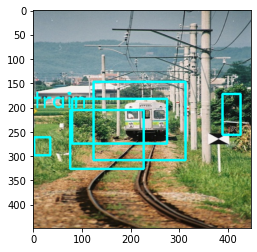

In [55]:
np_img = cv2.imread('./VOCdevkit_test/VOC2007/JPEGImages/000002.jpg')
resized_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))
np_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
resized_img = np_img
np_img = np_img.astype(np.float32)
np_img = np_img.astype(np.float32)
np_img = np_img / 255.0 * 2 - 1
np_img = np.reshape(np_img, (1, IMAGE_SIZE, IMAGE_SIZE, 3))

y_pred = YOLO(np_img, training=False)
xmin, ymin, xmax, ymax, class_num, conf = process_outputs11111(y_pred)
# print(class_num)
for i in range(len(xmin)):
    class_name = classes_name[class_num[i]]
    cv2.rectangle(resized_img, (int(xmin[i]), int(ymin[i])), (int(xmax[i]), int(ymax[i])), (0, 255, 255), 3)
    cv2.putText(resized_img, class_name, (0, 200), 2, 1.5, (0, 255, 255), 2)
    print(class_name)
    print(conf[i])
    print("xmin={},ymin={},xmax={},ymax={}".format(int(xmin[i]), int(ymin[i]), int(xmax[i]), int(ymax[i])))

plt.imshow(resized_img)
plt.show()